In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 计算图与PyTorch动态图机制

## 计算图

计算图：用于描述运算的有向无环图（DAG），在此DAG中，叶子是输入张量，根是输出张量
- 节点：表示数据，例如向量，矩阵，张量
- 边：表示运算，例如加减乘除，卷积

<img style="float: center;" src="images/2.png" width="70%">

计算图不仅可以计算变得更加简洁，也方便了梯度求导。

<img style="float: center;" src="images/3.png" width="70%">

y对w求导，就是从计算图中找到所有y到w的路径，使用链式法则进行求和。

通过从根到叶跟踪此图，可以使用链式规则自动计算梯度。

正向传播中，Autograd同时执行两项操作 ：
1. 运行请求的操作以计算结果张量
2. 在DAG中维护操作的梯度函数

当在DAG根目录上调用`.backward()`时，后退通道开始。

`autograd`然后：
1. 从每个`.grad_fn`计算梯度
2. 将它们累计在各自的张量的`.grad`属性中
3. 使用链式规则，一直传播到叶子张量

In [2]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward()
print(w.grad)   # tensor([5.])

tensor([5.])


### 张量属性—叶子节点（is_leaf）

用户创建的节点，比如上述的x和w

叶子节点非常关键，上述的正向计算和反向计算中，都依赖于叶子节点进行计算。

is_leaf：该张量是否是叶子节点

目的：节省内存，反向传播完成后，非叶子节点的梯度默认释放

In [3]:
#查看叶子结点
print("is_leaf:\n", w.is_leaf, x.is_leaf, a.is_leaf, b.is_leaf, y.is_leaf)

#查看梯度， 默认是只保留叶子节点的梯度的
print("gradient:\n", w.grad, x.grad, a.grad, b.grad, y.grad)

is_leaf:
 True True False False False
gradient:
 tensor([5.]) tensor([2.]) None None None


C:\Users\Huris\anaconda3\envs\sEMG\lib\site-packages\torch\_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten\src\ATen/core/TensorBody.h:417.)
  return self._grad


可以发现，只有w和x的is_leaf属性是True，说明它们是叶子节点。

gradient上，只有叶子节点的梯度被保留下来，分支节点a，b，y的梯度默认释放，为空。

如果想要保留某个分支节点的梯度，可以使用retain_grad方法。

即在执行反向传播前，执行一行代码a.retain_grad()即可。

In [4]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
a.retain_grad()
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward()

#查看梯度， 默认是只保留叶子节点的梯度的
print("gradient:\n", w.grad, x.grad, a.grad, b.grad, y.grad)

gradient:
 tensor([5.]) tensor([2.]) tensor([2.]) None None


### 张量属性—创建张量方法（grad_fn）

记录创建该张量时所用的方法/函数（两数相加/相乘，这样反向计算梯度的时候才能使用相应的法则求变量的梯度），主要用于梯度求导。

In [5]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
a.retain_grad()
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward()

# 查看 grad_fn   这个表示怎么得到的
print("grad_fn:\n", w.grad_fn, x.grad_fn, a.grad_fn, b.grad_fn, y.grad_fn)

grad_fn:
 None None <AddBackward0 object at 0x00000217C9649370> <AddBackward0 object at 0x00000217D2CDFA60> <MulBackward0 object at 0x00000217D2CDF700>


## PyTorch动态图机制

计算图搭建方式：
- 静态图：先搭建图，后运算。高效，不灵活（TensorFlow）
- 动态图：运算与搭建同时进行。灵活，易调节（PyTorch）

### TensorFlow

先建好图，然后开启一个session，在session中加入数据进行流动计算，该过程中，张量就会根据搭建好的图进行计算。

In [6]:
# 声明两个常量
w = tf.constant(1.)
x = tf.constant(2.)

# 搭建静态图
a = tf.add(w, x)
b = tf.add(w, 1)
y = tf.multiply(a, b)

# 这时候还没开始计算
print(y)   # Tensor("Mul_4:0", shape=(), dtype=float32)， 只是计算图的一个节点

with tf.Session() as sess:  
    print(sess.run(y))   # 这里才开始进行计算， 6.0

NameError: name 'tf' is not defined

### PyTorch

边建图边执行，比较灵活，有错误可以随时改。

In [7]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

print(y)    # tensor([6.], grad_fn=<MulBackward0>)

tensor([6.], grad_fn=<MulBackward0>)


# PyTorch自动求导机制

torch.autograd是PyTorch自动差分引擎，可为神经网络训练提供支持。

torch.autograd.backward(tensors, grad_tensors=None, retain_graph=None, create_graph=False)

- tensors：表示用于求导的张量，如loss
- grad_tensors：多梯度权重，多个loss需要计算梯度时，需要设置这些loss的权重比
- retain_graph：保存计算图，由于PyTorch采用动态图机制，每次反向传播后计算图都会被释放掉。如果不想被释放，可以设置为True
- create_graph：创建导数计算图，用于高阶求导

In [8]:
# backward()函数就是在调用torch.autograd.backward
def backward(self, gradient=None, retain_graph=None, create_graph=False):
    torch.autograd.backward(self, gradient, retain_graph, create_graph)

这里retain_graph默认为None，即一次反向传播后，计算图就会被释放掉，因此如果再次调用y.backward()程序就会报错

In [9]:
# 将其改为True的话可以维持计算图，之后再次调用backward()会再次进行梯度计算
y.backward(retain_graph=True)

grad_tensors：当有多个梯度的时候，控制梯度的权重

In [10]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)

y0 = torch.mul(a, b)  # y0 = (x + w) * (w + 1), dy0 / dw = 5
y1 = torch.add(a, b)  # y1 = (x + w) + (w + 1), dy1 / dw = 2

loss = torch.cat([y0, y1], dim=0)   # [y0, y1]

# 直接求loss会有报错，因为程序不知道用哪个梯度作为w的梯度
# loss.backward()

# 需要分配梯度权重
grad_tensors = torch.tensor([1., 1.])
loss.backward(gradient=grad_tensors)
print(w.grad)   #  这时候会是tensor([7.])   5+2

# grad_tensors = torch.tensor([1., 2.])
# loss.backward(gradient=grad_tensors)    
# print(w.grad)   #  这时候会是tensor([9.])   5+2*2

tensor([7.])


torch.autograd.grad()：求取梯度，可以实现高阶求导。

torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False)
- outputs：用于求导的张量，如loss
- inputs：需要梯度的张量，如w
- create_graph：创建导数计算图，用于高阶求导
- retain_graph：保存计算图
- grad_outputs：多梯度权重

In [11]:
x = torch.tensor([3.], requires_grad=True)
y = torch.pow(x, 2)   # y=x^2

# 一次求导
# 这里必须创建导数的计算图，grad_1 = dy/dx = 2x
grad_1 = torch.autograd.grad(y, x, create_graph=True)
print(grad_1)
# (tensor([6.], grad_fn=<MulBackward0>),)
# 这是个元组，二次求导的时候我们需要第一部分

# 二次求导
grad_2 = torch.autograd.grad(grad_1[0], x)  # grad_2 = d(dy/dx) /dx = 2
print(grad_2)  # (tensor([2.]),)

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


该函数还允许多个自变量求导

In [12]:
x1 = torch.tensor(1.0, requires_grad = True) # x需要被求导
x2 = torch.tensor(2.0, requires_grad = True)

y1 = x1 * x2
y2 = x1 + x2

# 允许同时对多个自变量求导数
(dy1_dx1, dy1_dx2) = torch.autograd.grad(outputs=y1, inputs = [x1,x2], retain_graph = True)
print(dy1_dx1, dy1_dx2)        # tensor(2.) tensor(1.)

# 如果有多个因变量，相当于把多个因变量的梯度结果求和
(dy12_dx1, dy12_dx2) = torch.autograd.grad(outputs=[y1, y2], inputs = [x1, x2])
print(dy12_dx1, dy12_dx2)        # tensor(3.) tensor(2.)

tensor(2.) tensor(1.)
tensor(3.) tensor(2.)


## 注意事项

### 梯度不自动清零

每一次反向传播，梯度都会叠加上去

In [13]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

for i in range(4):
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)

    y.backward()
    print(w.grad)

tensor([5.])
tensor([10.])
tensor([15.])
tensor([20.])


训练神经网络的时候，需要手动清除梯度

In [14]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

for i in range(4):
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)

    y.backward()
    print(w.grad)
    
    w.grad.zero_()  # 手动清除梯度

tensor([5.])
tensor([5.])
tensor([5.])
tensor([5.])


### 叶子节点的父节点，requires_grad默认为True

<img style="float: center;" src="images/3.png" width="70%">

该图中，w和x是叶子节点，其父节点是a和b，因此a和b默认需要计算梯度。

理解：计算w和x的梯度需要先对a和b进行求导，要用到a和b的梯度，所以这里直接默认a和b需要计算梯度。

In [15]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)

y = torch.mul(a, b)    # y0=(x+w) * (w+1) ，dy0 / dw = 5
print(w.requires_grad, a.requires_grad, b.requires_grad, y.requires_grad)

True True True True


### 叶子节点不可执行in-place（原位操作）

in-place（原位操作）：在原始内存中改变这个数据。

理解：以a+1为例，假设a=1，执行a=a+1，a变为2，但是这两个a指向的对象是不一样的（类似于字符串/元组，数字的不可变现象）。列表是可变的，假设a=[1, 5, 3]，可以a.append(4)，此时a指向的对象变成[1, 5, 3, 4]，但其实是在原对象[1, 5, 3]上进行添加，**此过程没有新对象产生**，执行a.sort()，a指向的对象为[1, 3, 4, 5]，但依然是源对象上进行了改变。

将数字进行原位操作后，这个数字就类似于列表这种，是在本身的内存中改变的数，这时候就没有新对象建立出来。a += 1 就是一种原位操作。

In [16]:
a = torch.ones((1,))
print(id(a), a)

# 我们执行普通的a = a+1操作
a = a + torch.ones((1,))
print(id(a), a)
# 会发现上面这两个a并不是同一个内存空间

# 那么执行原位操作呢？
a = torch.ones((1,))
print(id(a), a)
a += torch.ones((1,))
print(id(a), a)

2301186308832 tensor([1.])
2301344415968 tensor([2.])
2301343440064 tensor([1.])
2301343440064 tensor([2.])


叶子节点为何不能执行in-place（原位操作）？

RuntimeError：a leaf Variable that requires grad has been used in an in-place operation.

<img style="float: center;" src="images/3.png" width="70%">

求梯度的过程：

要求w的梯度的时候，先求$\frac{\partial{y}}{\partial{a}}=w+1$，后求$\frac{\partial{a}}{\partial{w}}$，即反向传播过程的$\frac{\partial{y}}{\partial{a}}$用到了$w$，是如何找到$w$的呢？

在正向传播的时候，会记录$w$的地址，之后反向传播的这一步，根据该地址去寻找$w$的值。如果在反向传播之前，用原位操作把$w$的值改变，则反向传播再取$w$值的时候，就会发生错误。

理解：去超市存包取包过程，管理员给一个号码牌10号，把包存入10号柜子，但之后管理员把10号柜子的包换成了别人的包，则取包的时候再拿10号的牌子取自己的包会发生错误。

# 逻辑回归模型

逻辑回归模型是**线性**的**二分类**模型，表达式如下：

$$
y=f(wx+b) \\
f(x)=\frac{1}{1+e^x}
$$

这里$f(x)$为sigmoid函数，也是logistic函数。

<img style="float: center;" src="images/4.png" width="50%">

## 二分类：根据y的取值进行分类

- y大于0.5，判为类别0
- y小于等于0.5，判为类别1

$$
\begin{equation}
class=
\left\{
\begin{aligned}
0 & , & 0.5 \gt y, \\
1 & , & 0.5 \le y.
\end{aligned}
\right.
\end{equation}
$$

## 线性

- 线性回归：自变量x，因变量y，关系y=wx+b，图像为一条直线。分析自变量x与因变量y之间关系的方法。注意此处线性针对w，一个w只影响一个x。决策边界为一条直线。
- 逻辑回归：自变量x，因变量y，此处y为概率。$y=f(wx+b),f(x)=\frac{1}{1+e^x}$，图像也是一条直线，分析自变量x与因变量y（概率）之间的关系。

注意：不要只看sigmoid函数就认为逻辑回归是非线性的，这个sigmoid函数在这里只是为了更好地描述分类置信度。如果不用这个函数，其实也可以进行二分类，比如wx+b>0，判定为1，wx+b<0，判定为0。会发现，依然是一个w只影响一个y，决策边界是一条直线，依然是线性的。

线性与非线性：
- 线性模型可以用曲线拟合样本，但是分类的决策边界一定是直线，例如logistic模型
- 区分是否为线性模型，主要是看一个乘法式子中自变量x前的系数w，如果w只影响一个x，则此模型为线性模型（或者判断决策边界是否线性）。

举例：
- 线性：$y=\frac{1}{1+e^{w_0+w_1x_1+w_2x_2}}$，$x_1$只被$w_1$影响
- 非线性：$y=\frac{1}{1+w_3e^{w_0+w_1x_1+w_2x_2}}$，$x_1$被$w_1$和$w_5$共同影响

## 逻辑回归又称对数几率回归

对数几率回归：线性回归是$y=wx+b$，如果把几率$\frac{y}{1-y}$（样X为正样本的可能性）取对数，让它等于$wx+b$，就叫对数几率回归，即$\ln\frac{y}{1-y}=wx+b$

化简公式：

$$
\ln\frac{y}{1-y}=wx+b \\
\frac{y}{1-y}=e^{wx+b} \\
y=e^{wx+b}-y*e^{wx+b} \\
y(1+e^{wx+b})=e^{wx+b} \\
y=\frac{e^{wx+b}}{1+e^{wx+b}}=\frac{1}{1+e^{-(wx+b)}}
$$

- 线性回归：用$wx+b$拟合数值$y$
- 对数几率回归：用$wx+b$拟合几率$\ln\frac{y}{1-y}$

## 机器学习模型训练步骤

1. 数据模块（数据采集、清洗、处理等）
2. 建立模型（各种模型的建立）
3. 损失函数（根据不同任务选择不同损失函数），有了loss就可以求取梯度
4. 优化器（根据梯度）
5. 迭代训练

神经网络（NN）是在某些输入数据上执行的嵌套函数的集合。这些函数由参数（由权重和偏差组成）定义，存储在张量中。

训练NN分为两个步骤：

1. 正向传播：NN对正确的输出进行最佳的猜测。通过其每个函数运行输入数据以进行猜测。
2. 反向传播：NN根据其猜测中的误差调整其参数，通过从输出向后遍历，收集有关函数参数（梯度）的误差导数并使用梯度下降优化参数来实现。

### 数据模块

随机生成2类样本（0和1表示），每一类样本100个，每个样本两个特征。

In [17]:
torch.manual_seed(1)

sample_nums = 100
mean_value = 1.7
bias = 1

n_data = torch.ones(sample_nums, 2)
x0 = torch.normal(mean_value * n_data, 1) + bias  # 类别0  数据shape=(100,2)
y0 = torch.zeros(sample_nums)   # 类别0， 数据shape=(100, 1)
x1 = torch.normal(-mean_value * n_data, 1) + bias   # 类别1， 数据shape=(100,2)
y1 = torch.ones(sample_nums)    # 类别1  shape=(100, 1)

train_x = torch.cat([x0, x1], 0)
train_y = torch.cat([y0, y1], 0)

### 建立模型

两种方式：
1. PyTorch的Sequential方法，简单易懂，一层一层往上搭。
2. 继承nn.Module类，灵活，能够搭建各种复杂的网络。

In [18]:
# Sequential方法
lr_net = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid()
)

In [19]:
# 继承nn.Module类
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        # Linear是module的子类，是参数化module的一种，与其名称一样，表示着一种线性变换。
        # 输入2个节点，输出1个节点
        self.features = torch.nn.Linear(2, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        
        return x

lr_net = LR()     # 实例化逻辑回归模型

### 损失函数

选择二进制交叉熵损失

In [20]:
loss_fn = torch.nn.BCELoss()

### 优化器

选择SGD优化器

In [21]:
lr = 0.01
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

### 迭代训练

循环中反复训练：前向传播，计算梯度，反向传播，更新参数，梯度清零

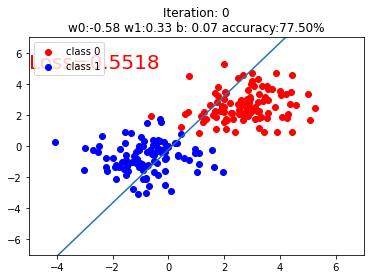

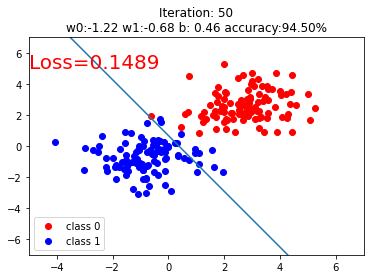

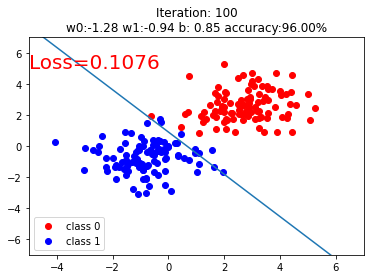

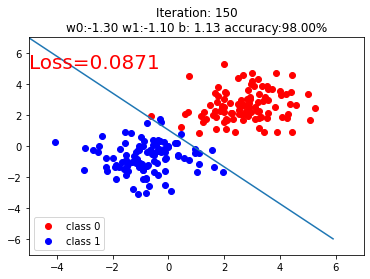

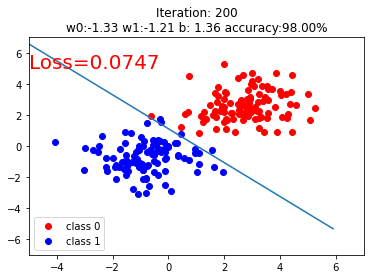

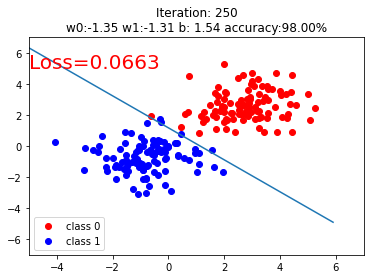

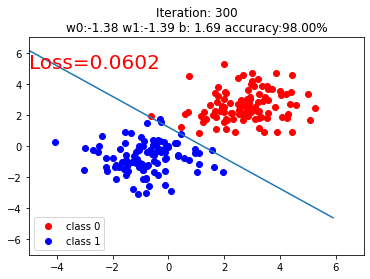

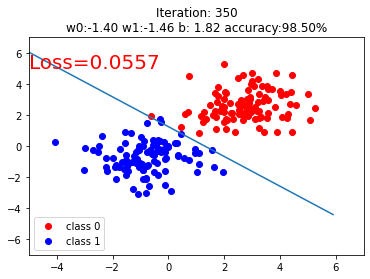

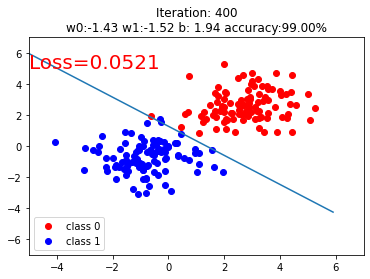

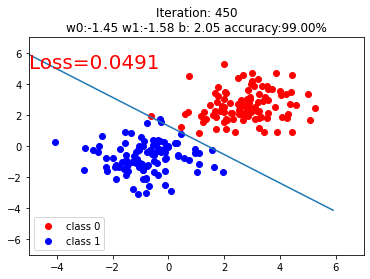

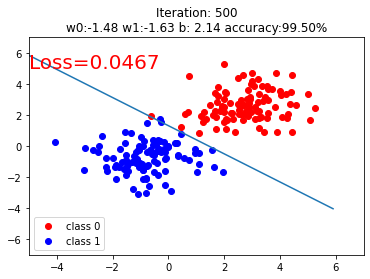

In [22]:
for iteration in range(1000):
    
    # 前向传播
    y_pred = lr_net(train_x)
    
    # 计算loss
    loss = loss_fn(y_pred.squeeze(), train_y)
    
    # 反向传播
    loss.backward()
    
    # 更新参数
    optimizer.step()
    
    # 清空梯度
    optimizer.zero_grad()
    
    # 绘图
    if iteration % 50 == 0:

        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.5)

        if acc > 0.99:
            break

# 思维导图

<img style="float: center;" src="images/5.png" width="100%">

# 使用autograd的向量微分

从数学上讲，对于一个向量值函数`y=f(x)`，则`y`相对于`x`的雅克比矩阵`j`

\begin{align}J
     =
      \left(\begin{array}{cc}
      \frac{\partial \bf{y}}{\partial x_{1}} &
      ... &
      \frac{\partial \bf{y}}{\partial x_{n}}
      \end{array}\right)
     =
     \left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}


一般来说，`torch.autograd`是用于计算向量雅克比积的引擎。即，对于给定任何向量`v`，计算乘积`J^T·v`

如果`v`恰好是标量函数的梯度


\begin{align}\vec{v}
   =
   \left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}\end{align}

则根据链式法则，向量雅克比积将是`v`相对于`x`的梯度

\begin{align}J^{T}\cdot \vec{v}=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\left(\begin{array}{c}
      \frac{\partial l}{\partial y_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial y_{m}}
      \end{array}\right)=\left(\begin{array}{c}
      \frac{\partial l}{\partial x_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial x_{n}}
      \end{array}\right)\end{align}

上述示例中使用的是vector-Jacobian乘积的这一特征。

`external_grad`表示`v`

# 冻结参数

`torch.autograd`跟踪所有将其`requires_grad`表示设置为`True`的张量操作。

对于不需要梯度的张量，将此属性设置为`False`会将其从梯度计算DAG中排除。

即使只有一个输入张量具有`requires_grad=True`，操作的输出张量也将需要梯度。

In [23]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients?: True


在NN中，不计算梯度的参数通常称为**冻结参数**

如果事先知道不需要这些参数的梯度，则“冻结”模型的一部分很有用（减少自动梯度计算）

从DAG中排除很重要的另一个常见用例是调整预训练网络

在微调中，我们冻结了大部分模型，通常仅修改分类器层以对新标签进行预测。

In [24]:
from torch import nn, optim
import torchvision

# 与之前一样，加载一个预训练的resnet18模型并冻结所有参数
model = torchvision.models.resnet18(pretrained=True)

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

假设要在具有10个标签的新数据集中微调模型。

在resnet中，分类器是最后一个线性层`model.fc`

可以简单地将其替换为充当我们的分类器的新线性层（默认情况下是未冻结的）

In [25]:
model.fc = nn.Linear(512, 10)

现在，除了`model.fc`的参数外，模型中的所有参数都将冻结。

计算梯度的唯一参数是`model.fc`的权重和偏差。

In [26]:
# Optimize only the classifier
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

注意，尽管在优化器中注册了所有参数，但唯一可计算梯度的参数（因此会在梯度下降中进行更新）是分类器的权重和偏差。

`torch.no_grad()`中的上下文管理器可以使用相同的排除功能。